In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv


In [2]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
#from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#building the model
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split
import re
from tqdm import tqdm_notebook
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tokenizers import BertWordPieceTokenizer, Tokenizer, models, pre_tokenizers, decoders, processors
from keras.utils.np_utils import to_categorical
#import tensorflow.keras.layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

import transformers
from transformers import TFAutoModel, AutoTokenizer

import os
import glob

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [6]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train['comment_text'] = train['comment_text'].apply(remove_punctuation)
valid['comment_text'] = valid['comment_text'].apply(remove_punctuation)
test['content'] = test['content'].apply(remove_punctuation)

In [7]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(removesw)
valid['comment_text'] = valid['comment_text'].apply(removesw)
test['content'] = test['content'].apply(removesw)

In [8]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)
valid['comment_text'] = valid['comment_text'].apply(stemming)
test['content'] = test['content'].apply(stemming)

**Model**

In [9]:
#Function for Encoding the comment

def regular_encode(texts, tokenizer, maxlen=512):
        # encode the word to vector of integer

    encode_dictionary = tokenizer.batch_encode_plus(texts, return_attention_masks=False, return_token_type_ids=False,
    pad_to_max_length=True,max_length=maxlen, truncation=True)
    
    return(np.array(encode_dictionary['input_ids']))

In [10]:
#Function for Neural Network Model

def build_model(transformer, max_len=512):

#Input: for define input layer
#shape is vector with 512-dimensional vectors
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
# to get the vector
    cls_token = sequence_output[:, 0, :]
# define output layer
    out = Dense(1, activation='sigmoid')(cls_token)
# initiate the model with inputs and outputs
    model = Model(inputs=input_word_ids, outputs=out)
# get the learning rate adam(1e-5) and the metrica
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    return(model)

In [11]:
EPOCHS = 3
BATCH_SIZE = 16 #* strategy.num_replicas_in_sync # the batch size in each epoch (128)
MAX_LEN = 192

# distilbert pre-trained model is faster than the bert base model, but it give lower accuracy than the bert base
#MODEL ='distilbert-base-multilingual-cased'
#MODEL='bert-base-multilingual-cased'

MODEL='bert-base-multilingual-cased'

In [12]:
AUTO = tf.data.experimental.AUTOTUNE

In [13]:
#use the pre-trained model BERT as a tokenizer 
#bert tokenizer has vocabulary for emoji

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [14]:
%%time 
#call the function regular encode on for all the 3 dataset to convert each words after the tokenizer
#into a vector
#x_train,x_test, and x_validation will have the comment text column only,(in test called "content")

x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

#y_train,y_valid will have te target column "toxic"
y_train = train.toxic.values
y_valid = valid.toxic.values

CPU times: user 8min 54s, sys: 1.21 s, total: 8min 55s
Wall time: 8min 55s


In [15]:
# Create and prepare a source dataset from your input data to fit the model in the next step.
# Apply dataset transformations to preprocess the data.
# Iterate over the dataset and process the elements.

train_dataset = (
    tf.data.Dataset # create dataset
    .from_tensor_slices((x_train, y_train)) # Once you have a dataset, you can apply transformations 
    .repeat()
    .shuffle(2048,seed=40) # Combines consecutive elements of this dataset into batches.
    .batch(BATCH_SIZE)
    .prefetch(AUTO)) #This allows later elements to be prepared while the current element 
                      #is being processed (pipline).


valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(BATCH_SIZE)
    .cache().prefetch(AUTO))

test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

In [16]:
%%time
# in the TPU
with strategy.scope():
    #take the encoder results of bert from transformers and use it as an input in the NN model
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 192, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 177,854,209
Trainable params: 177,854,209
Non-trainable params: 0
_________________________________________________________________
CPU times: user 47.6 s, sys: 16.4 s, total: 1min 4s
Wall time: 1min 3s


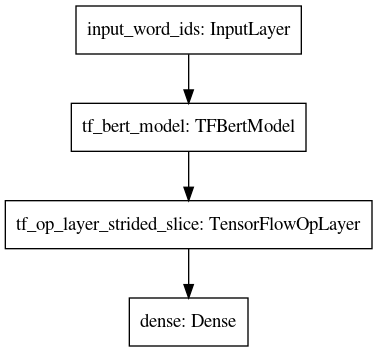

In [17]:
#visualize the model's architecture
tf.keras.utils.plot_model(model)

In [18]:
# train the model
# training the data and tune our model with the results of the metrics we get from the validation dataset
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(train_dataset, steps_per_epoch=n_steps, validation_data=valid_dataset,
                epochs=EPOCHS)

Epoch 1/3
13971/13971 [==============================] - 1153s 83ms/step - loss: 0.1226 - auc: 0.9637 - val_loss: 0.6263 - val_auc: 0.7737
Epoch 2/3
13971/13971 [==============================] - 1141s 82ms/step - loss: 0.0961 - auc: 0.9795 - val_loss: 0.5147 - val_auc: 0.7914
Epoch 3/3
13971/13971 [==============================] - 1146s 82ms/step - loss: 0.0782 - auc: 0.9867 - val_loss: 0.8257 - val_auc: 0.6610


In [22]:
#test the model on validation
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(valid_dataset.repeat(), steps_per_epoch=n_steps,epochs=EPOCHS*2)

Epoch 1/6
500/500 [==============================] - 40s 80ms/step - loss: 0.3099 - auc: 0.8491
Epoch 2/6
500/500 [==============================] - 40s 80ms/step - loss: 0.1880 - auc: 0.9530
Epoch 3/6
500/500 [==============================] - 39s 78ms/step - loss: 0.1003 - auc: 0.9867
Epoch 4/6
500/500 [==============================] - 40s 80ms/step - loss: 0.0546 - auc: 0.9949
Epoch 5/6
500/500 [==============================] - 40s 81ms/step - loss: 0.0341 - auc: 0.9967
Epoch 6/6
500/500 [==============================] - 40s 80ms/step - loss: 0.0263 - auc: 0.9983


In [23]:
from keras.models import load_model

In [19]:
# save model
model.save_weights('BERT_model_weights.h5')

In [24]:
print(train_history.history.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


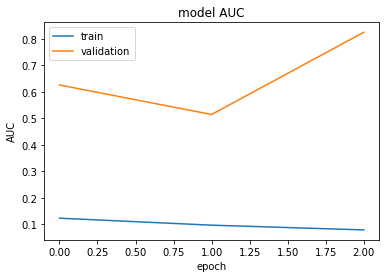

In [25]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()